In [10]:
import ast
import random
import math
import string
import pickle
import json
from copy import deepcopy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import sys
from torch_geometric.data import Data
from torch.nn import Dropout
from tqdm import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

import pandas as pd
#www.python-graph-gallery.com

In [14]:
USE_FULL_FEATURES = False
USE_BRANDS_AND_INGR = True
MASK = False
LOAD_SUB_FROM_FILE = True
USE_FREQUENCY = False
LOAD_BALANCED_DATA = True
INGREDIENT_TO_CLASSIFY = 'egg'#
STEM = True
REPLACE = True
REMOVE_REPLACE = False
if STEM:
    ps = PorterStemmer()
    words = [ps.stem(word) for word in INGREDIENT_TO_CLASSIFY.split(' ')]
    s = ''
    for word in words:
        s += word

if REPLACE:
    with open('replace_words.json') as f:
        replacements = json.load(f)
        for each in replacements.keys():
            replacements[each] = ast.literal_eval(replacements[each])
    
if LOAD_SUB_FROM_FILE:
    df = pd.read_csv(f'UNBALANCED_{INGREDIENT_TO_CLASSIFY}_balanced_data.csv')
else:
    files = [
        "outputs/food_1_Y.csv",
        "outputs/food_2_Y.csv",
        "outputs/food_3_Y.csv"
    ]

    df = pd.DataFrame()
    for file in files:
        df = pd.concat([df, pd.read_csv(file)])

    #df = df[df.index < int(len(df.index)/50)]
    df = df.sample(int(len(df.index)/1), random_state=123456789)
    #df = df.dropna()
    df = df.reset_index()

with open('stopwords.txt', 'r') as f:
    stopwords = []
    for l in f:
        if l not in stopwords:
            stopwords.append(l.replace('\n',''))
#Add a list of the ingredients, and concatenate palm oil products to be just palm oil
ingredients = [[x.lower() for x in ast.literal_eval(product['ingredients'])] for _,product in df.iterrows()]
df['ingredients_list'] = ingredients



drop_sparse_idx = []
c = []
banned_words = ['nan', 'none', 'na']
trans = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for row_idx, row in tqdm(df.iterrows()):
    if row['brand'] == math.nan:
        drop_sparse_idx.append(row_idx)
    len_ing = len(row['ingredients_list'])
    if len_ing==0:
        drop_sparse_idx.append(row_idx)
    elif len_ing == 1 and row['ingredients_list'][0].lower() in banned_words:
        drop_sparse_idx.append(row_idx)
    else:        
        idx = 0
        idx_to_remove = []
        while idx<len(row['ingredients_list']):
            if idx>1000:
                print(row['ingredients_list'][idx])
            row['ingredients_list'][idx] = row['ingredients_list'][idx].translate(trans)           
            if row['ingredients_list'][idx] in replacements.keys():
                #NEED TO DO THIS. SIMPLE GET THE VALUES IN replacements. CAN'T APPEND IN LOOP, BUT YOU COULD DO A WHILE LOOP
                idx_to_remove.append(idx)
                row['ingredients_list'].extend(replacements[row['ingredients_list'][idx]])             
            idx+=1
        if REMOVE_REPLACE:
            for i in reversed(idx_to_remove):
                row['ingredients_list'].pop(i)

df = df.drop(drop_sparse_idx)
drop_sparse_idx = []
for row_idx, row in df.iterrows():
    pop_li = []
    for idx, each in enumerate(row['ingredients_list']):
        stop_row_li = np.array(row['ingredients_list'][idx].split(' '))
        for stopword in stopwords:
            stop_loc = np.where(stop_row_li ==stopword)
            if len(stop_loc[0])>0:
                stop_row_li= np.delete(stop_row_li,stop_loc)
                str_ = ''
                for stringify_ in stop_row_li:
                    str_ += ' ' + stringify_
                row['ingredients_list'][idx] = str_
        if STEM:
            sentence = row['ingredients_list'][idx]
            words = [ps.stem(word) for word in sentence.split(' ')]
            s = ''
            for word in words:
                s += word
            row['ingredients_list'][idx] = s
            row['ingredients_list'][idx] = row['ingredients_list'][idx].replace(' ', '')
        if row['ingredients_list'][idx] == '':
            pop_li.append(idx)
        else:
            each = row['ingredients_list'][idx]
            if all(item in each.lower() for item in INGREDIENT_TO_CLASSIFY.lower().split()):
                c.append(each.lower())
                row['ingredients_list'][idx] = INGREDIENT_TO_CLASSIFY.lower()
    if pop_li:
        for each in reversed(pop_li):
            row['ingredients_list'].pop(each)
        if len(row['ingredients_list']) == 0:
            drop_sparse_idx.append(row_idx)

df = df.drop(drop_sparse_idx)

df = df[['index', 'name','brand','categories','price_max','price_min','ingredients','ingredients_list']]
df = df.dropna()
df

4920it [00:01, 3502.09it/s]


,index,name,brand,categories,price_max,price_min,ingredients,ingredients_list
0,1939,Simply Scrumptous Low Fat Chocolate Chunk Cookies,Simply Scrumptous,"['Grocery & Gourmet Food', 'Cookies', 'Cookie ...",17.60,17.60,"['whole wheat flour', 'chocolate chunks sugar'...","[wholewheatflour, chocolchunksugar, chocol, co..."
1,5420,Campbell's Chunky Creamy Chicken & Dumplings Soup,Campbell's,"['Soup', 'Household & Grocery', 'Food & Snacks...",3.49,3.49,"['water', 'chicken stock', 'sodium phosphate',...","[water, chickenstock, sodiumphosphat, monosodi..."
2,6125,Campbell's Chunky Classic Chicken Noodle Soup ...,Campbell's,"['Soup', 'Food Snacks', 'Household & Grocery',...",3.59,3.39,"['water', 'chicken stock', 'monosodium glutama...","[water, chickenstock, monosodiumglutam, thiami..."
3,7572,"100 Grand Candy Bar, Milk Chocolate and Carame...",100 Grand,"['Candy', ' Gum & Mints', 'Chocolate', 'Candy ...",38.99,24.67,"['high fructose corn syrup', 'butter', 'chocol...","[fructoscornsyrup, butter, chocol, cocoabutter..."
4,3647,Jeff Nathan Creations Chef Gourmet Panko Plain...,Jeff Nathan Creations,"['Cooking & Baking', 'Breadcrumbs & Seasoned C...",96.68,10.88,"['tapioca starch', 'water', 'potato starch', '...","[tapiocastarch, water, potatostarch, potatoflo..."
...,...,...,...,...,...,...,...,...
4915,5191,Lawry's Spaghetti Sauce Spatini,Lawry's,"['Grocery & Gourmet Food', 'Seasoning Mixes', ...",61.22,9.22,"['salt', 'sugar', 'onion', 'potato starch', 's...","[salt, sugar, onion, potatostarch, spiceinclud..."
4916,3671,Extra Large Rock Candy Sticks (22g): 12 Green ...,Espeez,"['Grocery & Gourmet Food', 'Candy & Chocolate'...",14.97,14.97,"['pure cane sugar', 'less than of the followin...","[canesugar, flavor, red, blue, red, yellow, ye..."
4917,7986,Stone Cold India Pale ALE Home Brew Beer Recip...,Home Brew Stuff,"['Grocery & Gourmet Food', 'Food & Beverage Gi...",46.98,42.19,['recipe kit includes highest quality fresh fo...,[recipkitincludhighestqualitigallonbeerspecial...
4918,4360,Campbell'sÂ Condensed Chicken Gumbo Soup,Campbell's,"['Soups', ' Stocks & Broths', 'Grocery & Gourm...",17.76,12.00,"['water', 'chicken stock', 'tomato puree water...","[water, chickenstock, tomatowater, tomatopast,..."


In [15]:
brand = {}
num_palm = 0
for idx,row in df.iterrows():
    for each in row['ingredients_list']:
        if INGREDIENT_TO_CLASSIFY in each.lower():
            #print("Name: %s ## Ingredient: %s" % (row['name'], each))            
            num_palm += 1
            br = row['brand']
            brand[br] = brand[br] + 1 if br in brand.keys() else 1
print(num_palm/len(df.index), len(df.index)/len(df.index))

0.4268292682926829 1.0


In [16]:
#df = df[["name", "ingredients"]]
df = df.drop_duplicates(subset="name")
# if 'level_0' in df.columns:
#     df = df.drop('level_0', axis=1)
df = df.reset_index()


#unique_ingred = np.unique(sum(df["ingredients"].apply(ast.literal_eval).values.tolist(), []))
unique_names = df['name'].unique()
unique_brands = df['brand'].unique()
#unique_mans = df['manufacturer'].unique()
unique_cats = np.unique(sum(df["categories"].apply(ast.literal_eval).values.tolist(), []))
unique_names = sorted(unique_names)
#unique_ingred = sorted(unique_ingred)

unique_ingred = []
for x in df['ingredients_list']:
    for y in x:
        if y not in unique_ingred:
            unique_ingred.append(y)

for i in unique_ingred:
    print(i)

print(len(set(unique_ingred)), len(unique_ingred))
# ui = np.unique(np.ndarray(df['ingredients_list']))


# G = igraph.Graph()
# G.add_vertices(len(unique_names))
# print(len(unique_names), len(df.index))
# #print(G.nodes['Once Upon a Farm Organic'])

wholewheatflour
chocolchunksugar
chocol
cocoa
butter
milk
soylecithin
flavor
sugar
egg
oatfiber
defatbutter
vanilla
bakesoda
palmoil
cocoabutter
emulsifi
water
chickenstock
sodiumphosphat
monosodiumglutam
thiaminmononitr
betacaroten
riboflavin
durumwheatflourdurumwheatflour
turmer
greenbean
maltbarleyflour
buttercreammilk
salt
celeri
spaetzldumplwater
wheatflour
chickenmeat
onion
pea
chicken
spice
soyprotein
creamcreammilk
vegetoil
chickenchickenstock
niacin
starch
carrot
wheatflourwheatflour
spaetzldumpl
ferrousulfat
folicacid
whitechickenmeat
carrageenan
potatostarch
canolaoil
fructoscornsyrup
anflavor
milkfat
soyglutenmilk
cornsyrup
coconutoil
barleymalt
milkchocolsugar
flavoronpeanut
vanillin
monodiglycerid
milklactos
crispricericeflour
tapiocastarch
potatoflour
vinegar
honey
cocoaprocessalkali
milkchocolsugarcornsyruphydrogenpalmkerneloil
cocoaprocessalkalisalt
milkchocol
palmkerneloil
palmkerneloilpalmoil
flavorpeanut
twixminimilkchocolsugar
soylecithinflavor
peanutmilkiwayminimi

In [17]:
for ing in unique_ingred:
    if 'peanut' in ing:
        print(ing)

flavoronpeanut
flavorpeanut
peanutmilkiwayminimilkchocolsugar
peanut
peanutbutterdriroastpeanut
rosemariextractonsharelinesoylecithindediccontainnopeanut
sulphitlupincaresourctestpeanut
honeyroastpeanutpeanut
vegetoilpeanut
peanutbutterchipsugar
defatpeanutflour
peanutbutterpeanut
peanutbuttercandisugar
defatpeanut
peanutbuttercoatpretzelballpeanutbuttercoatsugar
minipeanutbuttercupmilkchocolsugar
soybeansunflowseedpeanut
peanutbutter
peanuttreenut
blueproducpeanut
sunflowoilprocessonpackagpeanut
rawspanishpeanut
peanutflour
emulsififlavourtracepeanut
redmanufacturpeanuttreenut
roastpeanut
bluepreservbytbhqcitricacidpeanutsoymanufacturonmanufacturcontainmilk
milksoymanufacturonsharepeanut
peanutothertreenut
wheatpeanut
milksoytracepeanut
peanutbuttercoatsugar
peanutoil
peanutextract
peanutsoybeanareuse
treenutpeanut
peanutsoy
produconpeanut
soywheatpeanutmmmilkchocolcandimilkchocolsugar
gumacaciamilksoypeanut
reespeanutbuttercut
wheatpeanutmmmilksoypeanutmusketmilk
bluesnickerpeanut
so

In [18]:
def get_feature_matrix():
    feature_mat = np.zeros((len(unique_names),len(unique_ingred)),dtype=int)
    for idx, row in df.iterrows():
        ingr = row['ingredients_list']
        for ing_idx,each in enumerate(unique_ingred):
            feature_mat[idx,ing_idx] = 1 if each in ingr else 0
    return feature_mat

# def get_weighted_adj_mat(feature_mat, adj_mat):
#     if feature_mat.shape[0]
def get_feature_coocurrance():    
    feature_mat = dict()
    for each in range(len(unique_ingred)):
        feature_mat[each] = np.zeros((len(unique_ingred)),dtype=int)

    for idx, row in df.iterrows():
        ingr = row['ingredients_list']#ast.literal_eval(row['ingredients'])
        for ing_idx,each in enumerate(unique_ingred):
            if each in ingr:
                for ing_idx2,each2 in enumerate(unique_ingred):
                    if each2 in ingr:
                        #Minus the value along the diagonal. Prevents inteference with the coocurrance but also allows us to retrieve magnitude later
                        feature_mat[ing_idx][ing_idx2] += 1 if ing_idx!=ing_idx2 else -1
    return feature_mat

def get_cooccurance_tf_idf(palm_oil_cooccurance_vector):
    # Adapted from TF-IDF.
    # IDF = log(n/j) where n = total number of documents and j = number of documents containing a given term. This is kept the same, but squared
    # TF is the frquency of a term in a *given* document. This doesn't really apply here, but instead we..
    # || consider the frequency of a term (i.e. ingredient) in products that also contain palm oil (i.e. co-occurance)

    n = len(unique_names)

    #IMPORTANT We initialise the array to 1 rather than 0 at present, this is to avoid 0 divides in the math.log without having to iterate over idf to check and then skip the log step due to time complexity
    idf = np.ones(len(unique_ingred))
    for idx,row in df.iterrows():
        ingr_list = row['ingredients_list']#ast.literal_eval(row['ingredients'])
        for i,ingredient in enumerate(unique_ingred):
            idf[i] += 1 if ingredient in ingr_list else 0
        
        
        idf = np.array([math.log(n/j) for j in idf])
    #assert len(palm_oil_cooccurance_vector) == len(idf)

    tf_idf_vector = palm_oil_cooccurance_vector * np.square(idf)
    return tf_idf_vector

def get_information_entropy(cooccurance_matrix, palm_oil_idx, num_palm_oil, num_total_products):
    #Intuition: use information entropy to calculate how much information each other ingredient can give us on the presence of palm oil
    # - (P(palm_oil_presence|x) log(P(palm_oil_presence|x))) + (P(¬palm_oil_presence|x) log(P(¬palm_oil_presence|x)))
    def calculate_entropy(palm_presence, n):
        if n != 0:
            p1 = palm_presence/n
        else:
            p1 = 0
        p2 = 1-p1
        sum1 = 0 if p1==0 else (p1*math.log2(p1))
        sum2 = 0 if p2==0 else (p2*math.log2(p2))
        return - sum1 + sum2
    
    def calcalate_conditional_entropy(palm_presence, n, p_n):
        if p_n < 0:
            print(p_n)
            exit()
        if n!= 0:
            p1 = (palm_presence/n)*p_n
        else:
            p1 = 0
        assert p1 >=0
        assert p_n >=0
        sum1 = 1 if (p1<=0 or p_n<=0) else (1 + (p1*math.log2(1+(p1/p_n))))
        if sum1 <= 0:
            print(p1, p_n, palm_presence, n)
        return sum1

    n = len(unique_ingred)
    entropies = np.empty(n) 
    for idx,each in enumerate(cooccurance_matrix[palm_oil_idx]):
        if idx == palm_oil_idx:
            entropies[idx] == 100
        else:
            n_occ = -cooccurance_matrix[idx][idx]
            assert n_occ >= each, (unique_ingred[idx])
            entropies[idx] = (calcalate_conditional_entropy(each, n_occ, n_occ/num_total_products) + 
                                calcalate_conditional_entropy(each, num_total_products-n_occ, (num_total_products-n_occ)/num_total_products) + 
                                calcalate_conditional_entropy(n_occ-each, n_occ, n_occ/num_total_products) + 
                                calcalate_conditional_entropy(n_occ-each, num_total_products-n_occ, (num_total_products-n_occ)/num_total_products)
                                )
    return entropies        
    # for idx, row in df.iterrows():
    #     ingr_list = ast.literal_eval(row['ingredients'])
    #     for i, ingredient in enumerate(ingr_list):


        



    

In [19]:
def get_adj_matrix_from_features(feature_mat):
    adj_mat = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    for idx, col in enumerate(feature_mat.T):
        elements = np.where(col==1)[0]
        for i in elements:
            for j in elements:
                adj_mat[i,j] += 1 if i!=j else 0 
    return adj_mat

def get_adj_matrix_from_extra_features(feature_mat):
    adj_mat = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    shared_features = np.zeros((len(unique_names), len(unique_names)), dtype=int)
    for idx, col in enumerate(feature_mat.T):
        elements = np.where(col==1)[0]
        for i in elements:
            for j in elements:
                adj_mat[i,j] += 1 if i!=j else 0
                shared_features[i,j] = idx
    return (adj_mat, shared_features)

def get_adj_list_from_features(graph,feature_mat):
    adj_list = dict()

    # for node in range(len(list(graph.vs))):
    #     node_idx = node
    #     adj_list[node_idx] = {}
    for idx, col in enumerate(feature_mat.T):
        elements = np.where(col==1)[0]
        if len(elements) > 0:
            for i in elements:
                assert len([_ for _ in elements]) > 0
                adj_list[i] = [_ for _ in elements]
                adj_list[i].remove(i)
    for each in adj_list.keys():
        adj_list[each] = list(set(adj_list[each]))
    return adj_list
        

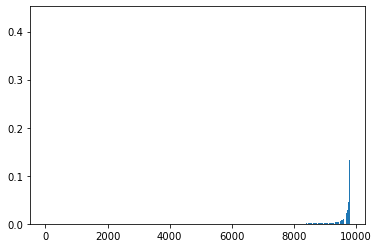

torch.Size([2, 9482902])


NameError: name 'train_mask' is not defined

In [20]:
import torch_geometric.transforms as transforms
from torch_geometric.loader import DataLoader
from torch_geometric.data import InMemoryDataset

def show_frequency():
  cooccurance_matrix = get_feature_coocurrance()
  freqs = []
  total_products = len(df.index)
  for idx in range(len(cooccurance_matrix[0])):
    freqs.append((-cooccurance_matrix[idx][idx])/total_products)
  plt.bar(range(len(freqs)), sorted(freqs))
  plt.show()

def piecewise_frequency_weighted_conditional_entropies(cooccurance_matrix, ordered_entropy, entropies, threshold_perc = 0.01):
  frequency_weighted_conditional_entropies = []
  total_products = len(df.index)
  fs = []
  min_frequency = 0.00

  def calculate_threshold():
      freqs = []
      total_products = len(df.index)
      for idx in range(len(cooccurance_matrix[0])):
        freqs.append((-cooccurance_matrix[idx][idx])/total_products)
        
      perc_idx = int(len(freqs)*threshold_perc)
      top_n_threshold = sorted(freqs, reverse=True)[perc_idx]
      zero_thresh = sorted(freqs, reverse=True)[0]
      print(perc_idx, top_n_threshold, zero_thresh)
      return top_n_threshold

  thresh = calculate_threshold()
  for idx in ordered_entropy:
      #Minus as you've made the diagonal minus for other reasons      
      if cooccurance_matrix[idx][idx]!=0:
          #n/f = 1/(f/n), f/n == frequency.
          fx = -cooccurance_matrix[idx][idx]
          frequency = (fx)/total_products
          fs.append(frequency)
          if frequency >= min_frequency:
              occurance = np.log(1/frequency) if frequency <= thresh else np.log(total_products/(total_products-fx))
              if occurance < 0:
                  print(f'less than zero, occ: {np.log(1/(total_products-fx))} with fx as {fx}')
              
              frequency_weighted_conditional_entropies.append(occurance*entropies[idx])
          else:
              frequency_weighted_conditional_entropies.append(1.0)
  return frequency_weighted_conditional_entropies


def frequency_weighted_conditional_entropies(cooccurance_matrix, ordered_entropy, entropies):
  frequency_weighted_conditional_entropies = []
  total_products = len(df.index)
  fs = []
  min_frequency = 0.00
  for idx in ordered_entropy:
      #Minus as you've made the diagonal minus for other reasons      
      if cooccurance_matrix[idx][idx]!=0:
          frequency = (-cooccurance_matrix[idx][idx])/total_products
          fs.append(frequency)
          if frequency >= min_frequency:
              occurance = np.log(1/frequency)
              if occurance < 0:
                  print("yes")
              
              frequency_weighted_conditional_entropies.append(occurance*entropies[idx])
          else:
              frequency_weighted_conditional_entropies.append(1.0)
  return frequency_weighted_conditional_entropies


def apply_entropy_mask(feature_matrix,top_n=2000, frequency_weighted=True):
  cooccurance_matrix = get_feature_coocurrance()
  #Print the highest co-occuring ingredients
  for idx,each in enumerate(unique_ingred):
      if (INGREDIENT_TO_CLASSIFY in each.lower()):
          palm_idx = idx
          palm_vector = cooccurance_matrix[idx]
          sorted_indicies = sorted(range(len(palm_vector)), key=lambda x: palm_vector[x], reverse=True)
          print("MOST CO-OCCURANCES: ",[(unique_ingred[x],palm_vector[x]) for x in sorted_indicies[:10]])
          break
  entropies = get_information_entropy(cooccurance_matrix, palm_idx, num_palm,len(df.index))
  ordered_entropy = sorted(range(len(entropies)), key=lambda x: entropies[x], reverse=False)
  
  if frequency_weighted:
    fwce = piecewise_frequency_weighted_conditional_entropies(cooccurance_matrix, ordered_entropy, entropies)
    fwce_ordered_entropy = sorted(range(len(entropies)), key=lambda x: fwce[x], reverse=False)
    unique_ingred_ = [unique_ingred[i_] for i_ in fwce_ordered_entropy[:top_n]]
    feature_matrix = get_feature_matrix() 
    return feature_matrix, fwce_ordered_entropy, unique_ingred_
  else:
    unique_ingred_ = [unique_ingred[i_] for i_ in ordered_entropy[:top_n]]
    feature_matrix = get_feature_matrix() 
    return feature_matrix, ordered_entropy, unique_ingred_

  # print([unique_ingred[idx] for idx in ordered_entropy[:5]])
  # print(entropies[ordered_entropy[0]], entropies[ordered_entropy[-1]])
  # mask = np.ones_like(feature_matrix)
  # mask[:,ordered_entropy[top_n:]] = 0
  # feature_matrix = feature_matrix * mask
  


def get_feature_vector_and_label(product, decision_ingredients):
  #Build feature vector of high entropy ingredients. 
  feature_vector = np.zeros(len(decision_ingredients))
  ingredients = product['ingredients_list']#ast.literal_eval(product['ingredients'])
  for dec_idx,decision_ingr in enumerate(decision_ingredients):
    #Check if ingredients is in feature list, and also make sure to mask the palm oil ingredient
    if unique_ingred[dec_idx] in ingredients and unique_ingred[dec_idx] != INGREDIENT_TO_CLASSIFY:      
      feature_vector[dec_idx] = 1
  #1 = palmy, 0 = non_palmy
  label = 1 if INGREDIENT_TO_CLASSIFY in ingredients else 0

  return (feature_vector, label)

def get_one_feature_vector(product, feature_key,unique_features, is_list=False):
  product_data = ast.literal_eval(product[feature_key]) if is_list else product[feature_key]
  feature_vector = np.zeros(len(unique_features))
  for feat_idx,feat in enumerate(unique_features):
    if (is_list and (feat in product_data)) or (feat==product_data):
      feature_vector[feat_idx] += 1
  return feature_vector

def get_balanced_dataset(df, test_perc, val_perc):
  df = df.drop('level_0', axis=1).reset_index()
  palmy_prods = []
  for idx,row in df.iterrows():
    for each in row['ingredients_list']:    
      if (INGREDIENT_TO_CLASSIFY in each):
        palmy_prods.append(row)

  palmy_df = pd.DataFrame(palmy_prods)
  #What % of the dataset is a positive class?
  proportion = len(palmy_df.index)/len(df.index)

  #Sample the same amount of non-palmy products
  df = df.drop(list(palmy_df.index))
  palmy_df = palmy_df.drop_duplicates(subset='index')


  palmy_test_sample_num = int(len(palmy_df)*test_perc)
  nonpalmy_test_sample_num = int(len(df.index)*test_perc)
  palmy_val_sample_num = int(len(palmy_df)*val_perc)
  nonpalmy_val_sample_num = int(len(df.index)*val_perc)

  sample_len = int(len(palmy_df.index)*(1-(test_perc+val_perc)))
  non_palmy_df = df.sample(sample_len+nonpalmy_test_sample_num+nonpalmy_val_sample_num)
  #assert len(palmy_df.index) == len(non_palmy_df.index)
  #Shuffle each df
  palmy_df = palmy_df.sample(frac=1).drop('level_0', axis=1).reset_index()
  non_palmy_df = non_palmy_df.sample(frac=1).drop('level_0', axis=1).reset_index()
  df=pd.concat([palmy_df, non_palmy_df]).drop('level_0', axis=1).reset_index()
  #print(len(palmy_df.index), len(df.index),proportion, nonpalmy_test_sample_num, palmy_test_sample_num, nonpalmy_val_sample_num,palmy_val_sample_num)


  train_mask,val_mask,test_mask = np.zeros(len(df.index)),np.zeros(len(df.index)),np.zeros(len(df.index))
  dflen, pdflen, npdflen = len(df.index),len(palmy_df.index),len(non_palmy_df.index)

  train_boundaries = (int((1-(test_perc+val_perc))*pdflen), (pdflen+npdflen-(nonpalmy_test_sample_num+nonpalmy_val_sample_num)))
  val_boundaries = (train_boundaries[0]+int(pdflen*val_perc), train_boundaries[1]+nonpalmy_val_sample_num)

  train_mask[:train_boundaries[0]] = 1
  train_mask[pdflen:train_boundaries[1]] = 1

  val_mask[train_boundaries[0]:val_boundaries[0]] = 1
  val_mask[train_boundaries[1]:val_boundaries[1]] = 1

  test_mask[val_boundaries[0]:pdflen]=1
  test_mask[val_boundaries[1]:]=1

  assert dflen == (pdflen+npdflen)
  assert dflen == sum([sum(x) for x in [test_mask, train_mask, val_mask]])

  print(sum(train_mask), sum(val_mask),sum(test_mask), len(df.index), pdflen, npdflen,palmy_test_sample_num,nonpalmy_test_sample_num)
  return (df, torch.tensor(train_mask, dtype=bool), torch.tensor(val_mask, dtype=bool), torch.tensor(test_mask, dtype=bool))

def drop_sparse(adjacency_matrix, feature_matrix):
  rows_to_drop = [idx for idx,row_ in enumerate(adjacency_matrix) if sum(row_)==0]
  assert feature_matrix.shape[0]==adjacency_matrix.shape[0]
  adjacency_matrix = np.delete(adjacency_matrix, rows_to_drop, axis=0)
  adjacency_matrix = np.delete(adjacency_matrix, rows_to_drop, axis=1)
  feature_matrix = np.delete(feature_matrix, rows_to_drop, axis=0)
  return adjacency_matrix,feature_matrix





if LOAD_BALANCED_DATA:
  df = pd.read_csv(f'UNBALANCED_{INGREDIENT_TO_CLASSIFY}_balanced_data.csv', converters={'ingredients_list': pd.eval})
  #load test/val/train mask
else:
  df,train_mask,val_mask,test_mask = get_balanced_dataset(df,0.1,0.1)
  df.to_csv(f'UNBALANCED_{INGREDIENT_TO_CLASSIFY}_balanced_data.csv')
  #picke test and val and train mask 


#df.to_csv('final_saved_balanced_dataset.csv')

feature_matrix = []
for idx, product in df.iterrows():
  feature_vector, label = get_feature_vector_and_label(product, unique_ingred)#get_feature_vector_and_label_with_brands(product, unique_ingred)
  feature_matrix.append(feature_vector)



unique_ingred = []
for x in df['ingredients_list']:
    for y in x:
        if y not in unique_ingred:
            unique_ingred.append(y)

show_frequency()

if MASK:  
  feature_matrix,ordered_entropy,unique_ingred=apply_entropy_mask(feature_matrix,int(len(unique_ingred)/2), frequency_weighted=USE_FREQUENCY)

#Get Matrix of Features -- Products x Features
feature_matrix = []
label_vector = []
edge_matrix = []
brand_vector = []
cat_matrix = []
for idx, product in df.iterrows():
  feature_vector, label = get_feature_vector_and_label(product, unique_ingred)#get_feature_vector_and_label_with_brands(product, unique_ingred)
  feature_matrix.append(feature_vector)
  label_vector.append(label)
  edge_matrix.append(get_one_feature_vector(product, 'brand',unique_brands))
  brand_vector.append(np.where(edge_matrix[idx] == 1)[0])
  cat_matrix.append(get_one_feature_vector(product,'categories',unique_cats, is_list=True))

#(adj_matrix,feature_matrix) = drop_sparse(get_adj_matrix_from_features(np.array(feature_matrix)), feature_matrix)



ingred_adj_matrix = get_adj_matrix_from_features(np.array(feature_matrix))
#adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(feature_matrix))

if USE_FULL_FEATURES:
  #Concatenate ingredients with brands and categories
  feature_matrix = np.concatenate((feature_matrix, edge_matrix, cat_matrix), axis=1)
  adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(feature_matrix))
elif USE_BRANDS_AND_INGR:
  feature_matrix = np.concatenate((feature_matrix, edge_matrix), axis=1)
  adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(feature_matrix))
else:
  #Get adjacency from just brands
  adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(edge_matrix))
  #adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(cat_matrix))
  #adj_matrix, shared_features = get_adj_matrix_from_extra_features(np.array(feature_matrix))


# adj_matrix = get_adj_matrix_from_extra_features(np.array(feature_matrix), len(unique_ingred))
# for col in adj_matrix:
#   print(len(np.where(col==1)[0]))


# if MASK:
#   feature_matrix, ordered_entropies = apply_entropy_mask(feature_matrix, top_n=int(len(feature_matrix[:][0])/7.5))

edge_index = []
edge_attr = []
edge_weights_ = []
for idx,_ in enumerate(adj_matrix):
  for target,val in enumerate(adj_matrix[idx]):
    if val >0:
      edge_index.append([idx,target])
      edge_weights_.append(ingred_adj_matrix[idx, target])
      edge_attr.append(shared_features[idx, target])

#To Tensor
feature_matrix = torch.tensor(feature_matrix, dtype=torch.float)
label_vector = torch.tensor(label_vector)
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
print(edge_index.shape)
edge_weights = torch.tensor([1 for _ in range(len(edge_weights_))], dtype=torch.float)#.t().contiguous()
edge_attr = torch.tensor(edge_attr, dtype=torch.float)#.t().contiguous()
edge_attr = torch.randn(edge_index.size(1))
transform = transforms.Compose([
    #transforms.RandomNodeSplit('train_rest', num_val=int(feature_matrix.shape[0]/10), num_test=int(feature_matrix.shape[0]/10)),
    transforms.TargetIndegree()
])
# print(feature_matrix.shape, label_vector.shape)
# print(len(np.where(label_vector==1)[0]),len(np.where(label_vector==0)[0]))

# class ProductDataset(InMemoryDataset):
#   def __init__(self, data, transform=None, pre_transform=None):
#     super().__init__(None, transform, pre_transform)
#     self.data = data
#     self.transform = transform
#     self.pre_transform = pre_transform 
  
#   def len(self):
#     return 1
  
#   def get(self,idx):
#     if self.pre_transform:
#       data = self.pre_transform(self.data)
#     if self.transform:
#       data = self.transform(self.data)
#     return data

# print(Data(x=feature_matrix, y=label_vector,edge_index=edge_index, edge_weight=edge_weights, edge_attr=edge_attr))
data = transform(Data(x=feature_matrix, edge_index=edge_index))
data.y=label_vector
data.edge_weight=edge_weights
data.edge_attr=edge_attr
data.train_mask=train_mask
data.val_mask=val_mask
data.test_mask=test_mask
#dataset = ProductDataset(data, transform=transform)
#dataloader = DataLoader(dataset, 
print(data)

# if MASK:
#   masked_data = deepcopy(data)
#   masked_data.x, ordered_entropies = apply_entropy_mask(masked_data.x, top_n=int(len(masked_data.x[:][0])/10))  


tensor([1, 1, 1,  ..., 0, 0, 0])


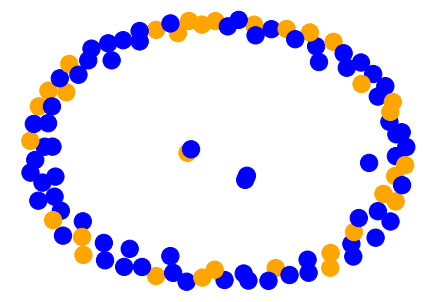

In [ ]:
from torch_geometric.utils import to_networkx
import networkx as nx


print(data.y[data.test_mask])
new_graph = to_networkx(data)
k=100

sampled_nodes = random.sample(new_graph.nodes,k)

sampled_graph = new_graph.subgraph(sampled_nodes)


#pos=nx.kamada_kawai_layout(sampled_graph)
cm = []
for node in sampled_graph:
    if data.y[node] ==1:
        cm.append('orange')
    else:
        cm.append('blue')

nx.draw(sampled_graph, node_color=cm)

In [ ]:
if MASK and USE_FREQUENCY:
    cooccurance_matrix = get_feature_coocurrance()
    #Print the highest co-occuring ingredients
    for idx,each in enumerate(unique_ingred):
        if (INGREDIENT_TO_CLASSIFY in each.lower()):
            palm_idx = idx
            palm_vector = cooccurance_matrix[idx]
            sorted_indicies = sorted(range(len(palm_vector)), key=lambda x: palm_vector[x], reverse=True)
            print("MOST CO-OCCURANCES: ",[(unique_ingred[x],palm_vector[x]) for x in sorted_indicies[:10]])
            break
    entropies = get_information_entropy(cooccurance_matrix, palm_idx, num_palm,len(df.index))
    ordered_entropy = sorted(range(len(entropies)), key=lambda x: entropies[x], reverse=False)

    print(f"Lowest Entropy Ingredients: {np.array(unique_ingred)[ordered_entropy[:11]]}")
    print(f"Highest Entropy Ingredients: {np.array(unique_ingred)[ordered_entropy[-10:]]}")

    print(sorted(entropies)[:10])

# for idx,each in enumerate(entropies):
#     if each <=0:
#         print(unique_ingred[idx])

In [ ]:
# sns.color_palette('Set2')
# sns.set_theme()
if MASK and USE_FREQUENCY:
    print(min(entropies), entropies[ordered_entropy[0]],entropies[ordered_entropy[-1]])

    '''
    Frequency-weighted conditional entropy = log(N/f) * H(Y|X)
    Where N is total number of products and f is the number of products that contain this ingredient

    '''
    frequency_weighted_conditional_entropies = []
    total_products = len(df.index)
    fs = []
    min_frequency = 0.00 #1%
    for idx in ordered_entropy:
        #Minus as you've made the diagonal minus for other reasons
        
        if cooccurance_matrix[idx][idx]!=0:
            frequency = (-cooccurance_matrix[idx][idx])/total_products
            fs.append(frequency)
            if frequency >= min_frequency:
                occurance = np.log(1/frequency)
                if occurance < 0:
                    print("yes")
                
                frequency_weighted_conditional_entropies.append(occurance*entropies[idx])
            else:
                frequency_weighted_conditional_entropies.append(1.0)
        else:
            print('Entropy', unique_ingred[idx])
    print(sorted(frequency_weighted_conditional_entropies)[:20])
    print(min(frequency_weighted_conditional_entropies),max(frequency_weighted_conditional_entropies))
    print(min(fs), max(fs), np.median(fs), np.mean(fs))


    fig,ax = plt.subplots()
    ax.set_title('IDF-Conditional Entropy of Ingredients For Palm Oil Prediction')
    ax.set_ylabel('IDF Conditional Entropy')
    ax.set_xlabel('Ingredients')
    ax.bar(np.arange(len(frequency_weighted_conditional_entropies)), sorted(frequency_weighted_conditional_entropies))
    plt.show()

In [ ]:
if MASK and USE_FREQUENCY:
    fig,ax = plt.subplots(1,2)
    ax[0].bar(np.arange(len(entropies)),sorted(entropies))
    #ax[0].set_xticklabels(np.array(unique_ingred)[ordered_entropy], rotation=45, ha='right')
    ax[0].set_xticks(np.arange(len(entropies)))

    ax[1].bar(np.arange(len(entropies[:20])),sorted(entropies[:20]))
    #ax[1].set_xticklabels(np.array(unique_ingred)[ordered_entropy[:20]], rotation=45, ha='right')
    ax[1].set_xticks(np.arange(len(entropies[:20])))
    ax[0].set_title('Conditional Entropy of Ingredients With Respect to Palm Oil')
    ax[1].set_title('Ingredients With Lowest Conditional Entropy With Respect to Palm Oil')

    plt.show()


In [ ]:
from torch_geometric.nn import GCNConv, GATv2Conv, NNConv,SAGEConv
from torch_geometric.nn.models import AttentiveFP 
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.transforms import NormalizeFeatures
from sklearn.manifold import TSNE
def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()




In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(MLP, self).__init__()
        #torch.manual_seed(12345)
        self.lin1 = Linear(len(data.x[0]), hidden_channels)
        self.lin2 = Linear(hidden_channels,2)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

# criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss

# def test():
#       class_correct = [0,0]
#       class_samples = [0,0]
#       model.eval()
#       out = model(data.x)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#       assert len(test_correct)==len(pred[data.test_mask])
#       #print(test_correct)
#       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#       p = pred[data.test_mask]
#       d = data.y[data.test_mask]      
#       for idx,each in enumerate(test_correct):
#           class_samples[d[idx]] += 1
#           if each == True:
#               class_correct[p[idx]] += 1
#       print(class_correct, class_samples)
#       print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#       return test_acc

# def masked_test():
#       class_correct = [0,0]
#       class_samples = [0,0]
#       model.eval()
#       out = model(masked_data.x)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[masked_data.test_mask] == masked_data.y[masked_data.test_mask]  # Check against ground-truth labels.
#       assert len(test_correct)==len(pred[masked_data.test_mask])
#       #print(test_correct)
#       test_acc = int(test_correct.sum()) / int(masked_data.test_mask.sum())  # Derive ratio of correct predictions.
#       p = pred[masked_data.test_mask]
#       d = data.y[masked_data.test_mask]      
#       for idx,each in enumerate(test_correct):
#           class_samples[d[idx]] += 1
#           if each == True:
#               class_correct[p[idx]] += 1
#       print(class_correct, class_samples)
#       print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#       return test_acc

# for epoch in range(1, 101):
#     loss = train()
#     print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# test_acc = test()
# print(f'Test Accuracy: {test_acc:.4f}')

# # if MASK:
# #     masked_test_acc = masked_test()
# #     print(f'Masked Test Accuracy: {masked_test_acc:.4f}')

MLP(
  (lin1): Linear(in_features=12979, out_features=16, bias=True)
  (lin2): Linear(in_features=16, out_features=2, bias=True)
)


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        #torch.manual_seed(12345)
        #print(len(set(data.y)))
        self.conv1 = GCNConv(len(data.x[0]), hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 2)

    def forward(self, x, edge_index, edge_weight):
        x = self.conv1(x, edge_index, edge_weight=edge_weight)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        return x

class GatV2ConvClass(torch.nn.Module):
    def __init__(self, hidden_channels, heads=4, edge_dim=1):
        super().__init__()
        self.edge_dim=edge_dim
        #torch.manual_seed(12345)
        #print(len(set(data.y)))
        self.conv1 = GATv2Conv(len(data.x[0]), hidden_channels, heads=heads)
        self.conv2 = GATv2Conv(hidden_channels*heads, 2)

    def forward(self, x, edge_index, edge_attr=None, size=None):
        x = self.conv1(x, edge_index, edge_attr, size)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index,edge_attr, size)
        return x


class SAGEConvClass(torch.nn.Module):
    def __init__(self, hidden_channels,dropout=0.5,edge_dim=1):
        super().__init__()
        self.edge_dim=edge_dim
        #torch.manual_seed(12345)
        #print(len(set(data.y)))
        self.conv1 = SAGEConv(len(data.x[0]), hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, 2)
        self.dropout_prob = dropout
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=self.dropout_prob, training=self.training)
        x = self.conv2(x, edge_index)
        return x
        

In [ ]:
# model = Net()
# model.eval()
# out = model(data.x, data.edge_index, data.edge_attr)
# visualize(out, color=data.y)
# print(model)


torch.Size([81062]) torch.Size([2, 81062])


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


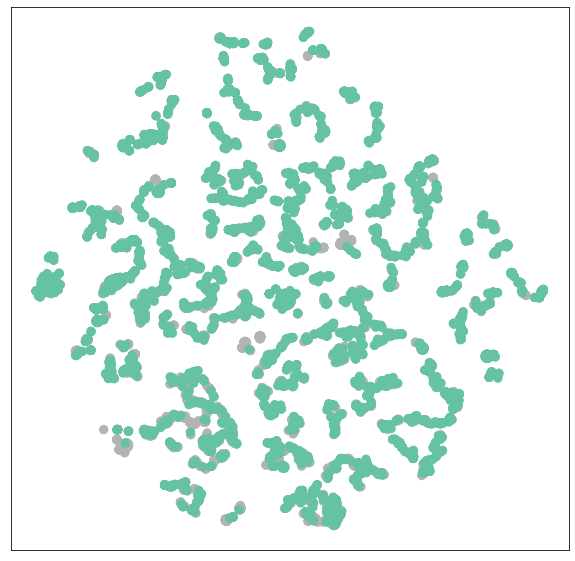

GCN(
  (conv1): GCNConv(12979, 16)
  (conv2): GCNConv(16, 2)
)


In [ ]:
model = GCN(hidden_channels=16)
model.eval()

print(data.edge_weight.size(), data.edge_index.size())
out = model(data.x, data.edge_index, data.edge_weight)
visualize(out, color=data.y)
print(model)
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x, data.edge_index, data.edge_weight)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss


# def validate():
#       model.eval()
#       out = model(data.x, data.edge_index, data.edge_weight)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
#       test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
#       return test_acc


# # def test():
# #       class_correct = [0,0]
# #       class_samples = [0,0]
# #       model.eval()
# #       out = model(data.x, data.edge_index)
# #       pred = out.argmax(dim=1)  # Use the class with highest probability.
# #       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
# #       #print(test_correct)
# #       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
# #       p = pred[data.test_mask]
# #       assert len(p) == len(test_correct)
# #       d = data.y[data.test_mask]      
# #       for idx,each in enumerate(test_correct):
# #             try:
# #                   class_samples[p[idx]] += 1
# #             except Exception as e:
# #                   print("BROKE", p[idx])
# #                   sys.exit()
# #             if each == True:
# #                   class_correct[p[idx]] += 1

# #       print(class_correct, class_samples)
# #       print([0 if class_samples[idx] == 0 else class_correct[idx]/class_samples[idx] for idx in range(2)])
# #       return test_acc

# def test():
#       class_correct = [0,0]
#       class_samples = [0,0]
#       model.eval()
#       out = model(data.x, data.edge_index, data.edge_weight)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#       assert len(test_correct)==len(pred[data.test_mask])
#       #print(test_correct)
#       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#       p = pred[data.test_mask]
#       d = data.y[data.test_mask]
      
#       for idx,each in enumerate(test_correct):          
#           class_samples[p[idx]] += 1
#           if each == True:
#               class_correct[p[idx]] += 1
#       print(class_correct, class_samples)
#       print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#       return test_acc

# # chans = [16,48,64,128]
# # lrs = [0.005,0.01,0.02]
# # decays = [1e-4,5e-4,9e-4]
# # for chan in chans:
# #       for lr in lrs:
# #             for decay in decays:
# #                   model = GCN(hidden_channels=chan)
# #                   optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
# #                   criterion = torch.nn.CrossEntropyLoss()
# #                   for epoch in range(1, 101):
# #                         loss = train()
# #                         #print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# #                         # if (epoch) % 25 == 0:
# #                         #       val_acc =validate()
# #                         #       print(f'Validate Accuracy: {val_acc:.4f}')

# #                   test_acc = test()
# #                   print(chan,lr,decay)
# #                   print(f'Test Accuracy: {test_acc:.4f}')

# model = GCN(hidden_channels=16)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# criterion = torch.nn.CrossEntropyLoss()
# for epoch in range(1, 201):
#       loss = train()
#       print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
#       if (epoch) % 25 == 0:
#             val_acc =validate()
#             print(f'Validate Accuracy: {val_acc:.4f}')
# test_acc = test()
# print(f'Test Accuracy: {test_acc:.4f}')

# model.eval()
# out = model(data.x, data.edge_index, data.edge_weight)
# visualize(out, color=data.y)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


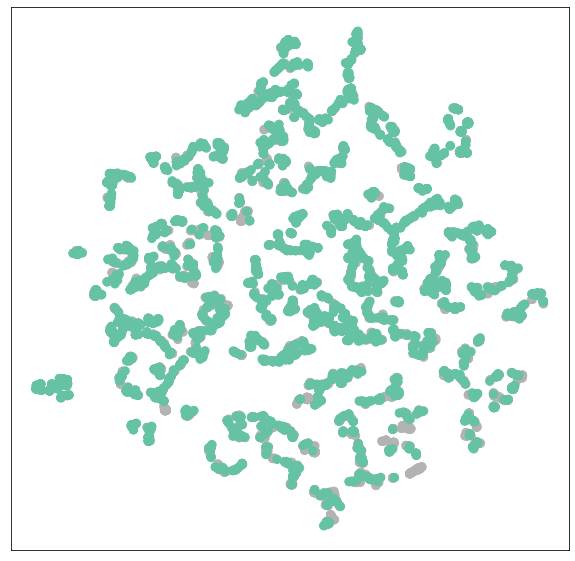

GatV2ConvClass(
  (conv1): GATv2Conv(12979, 16, heads=4)
  (conv2): GATv2Conv(64, 2, heads=1)
)


In [ ]:
model = GatV2ConvClass(hidden_channels=16)
model.eval()
out = model(data.x, data.edge_index)#, data.edge_attr)#, len(data.edge_attr))
visualize(out, color=data.y)
print(model)
model = GatV2ConvClass(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
# def train():
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x, data.edge_index)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss


# def validate():
#       model.eval()
#       out = model(data.x, data.edge_index)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
#       test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
#       return test_acc

# def test():
#       class_correct = [0,0]
#       class_samples = [0,0]
#       model.eval()
#       out = model(data.x, data.edge_index)
#       pred = out.argmax(dim=1)  # Use the class with highest probability.
#       test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#       assert len(test_correct)==len(pred[data.test_mask])
#       #print(test_correct)
#       test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#       p = pred[data.test_mask]
#       d = data.y[data.test_mask]
      
#       for idx,each in enumerate(test_correct):          
#           class_samples[d[idx]] += 1
#           if each == True:
#               class_correct[p[idx]] += 1
#       print(class_correct, class_samples)
#       print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#       return test_acc

# # model = GatV2ConvClass(hidden_channels=16)
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
# # criterion = torch.nn.CrossEntropyLoss()
# # for epoch in range(1, 101):
# #       loss = train()
# #       print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
# #       if (epoch) % 25 == 0:
# #             val_acc =validate()
# #             print(f'Validate Accuracy: {val_acc:.4f}')
# # test_acc = test()
# # print(f'Test Accuracy: {test_acc:.4f}')

# # model.eval()
# # out = model(data.x, data.edge_index)
# # visualize(out, color=data.y)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


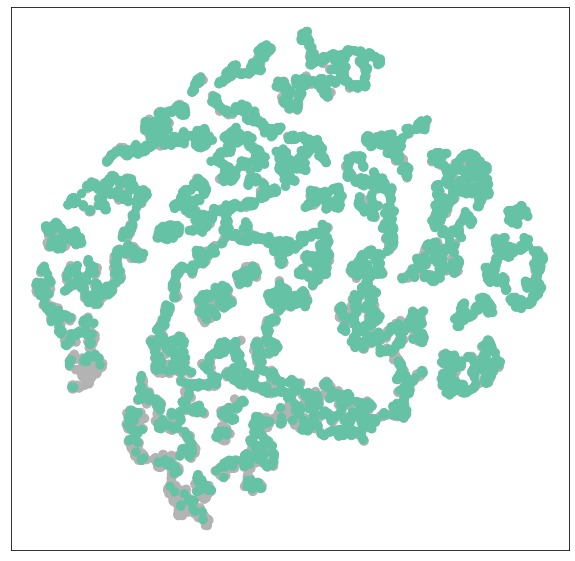

SAGEConvClass(
  (conv1): SAGEConv(12979, 16)
  (conv2): SAGEConv(16, 2)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SAGEConvClass(hidden_channels=16)
model.eval()
out = model(data.x, data.edge_index)#, data.edge_attr)#, len(data.edge_attr))
visualize(out, color=data.y)
print(model)
data = data.to(device)
model = SAGEConvClass(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

Epoch: 001, Loss: 0.6961
Epoch: 002, Loss: 0.6124
Epoch: 003, Loss: 0.5637
Epoch: 004, Loss: 0.5214
Epoch: 005, Loss: 0.4838
Epoch: 006, Loss: 0.4506
Epoch: 007, Loss: 0.4171
Epoch: 008, Loss: 0.3895
Epoch: 009, Loss: 0.3630
Epoch: 010, Loss: 0.3355
Epoch: 011, Loss: 0.3145
Epoch: 012, Loss: 0.2896
Epoch: 013, Loss: 0.2703
Epoch: 014, Loss: 0.2513
Epoch: 015, Loss: 0.2358
Epoch: 016, Loss: 0.2209
Epoch: 017, Loss: 0.2097
Epoch: 018, Loss: 0.1954
Epoch: 019, Loss: 0.1860
Epoch: 020, Loss: 0.1729
Epoch: 021, Loss: 0.1666
Epoch: 022, Loss: 0.1607
Epoch: 023, Loss: 0.1533
Epoch: 024, Loss: 0.1444
Epoch: 025, Loss: 0.1410
Validate Accuracy: 0.8763
Epoch: 026, Loss: 0.1381
Epoch: 027, Loss: 0.1325
Epoch: 028, Loss: 0.1292
Epoch: 029, Loss: 0.1206
Epoch: 030, Loss: 0.1256
Epoch: 031, Loss: 0.1179
Epoch: 032, Loss: 0.1115
Epoch: 033, Loss: 0.1116
Epoch: 034, Loss: 0.1078
Epoch: 035, Loss: 0.1074
Epoch: 036, Loss: 0.1057
Epoch: 037, Loss: 0.1054
Epoch: 038, Loss: 0.1039
Epoch: 039, Loss: 0.1013

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


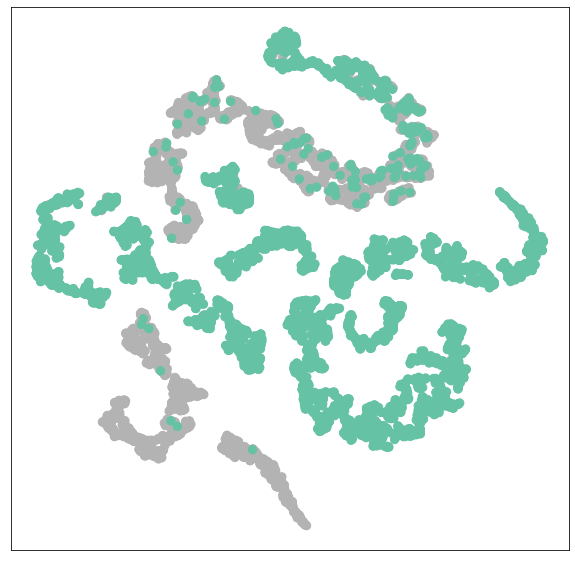

In [ ]:
def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss


def validate():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

def test():
      class_correct = [0,0]
      class_samples = [0,0]
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      assert len(test_correct)==len(pred[data.test_mask])
      #print(test_correct)
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      p = pred[data.test_mask]
      d = data.y[data.test_mask]
      
      for idx,each in enumerate(test_correct):          
          class_samples[p[idx]] += 1
          if each == True:
              class_correct[p[idx]] += 1
      print(class_correct, class_samples)
      print([class_correct[idx]/class_samples[idx] for idx in range(2)])
      return test_acc

model = SAGEConvClass(hidden_channels=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()
for epoch in range(1, 51):
      loss = train()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
      if (epoch) % 25 == 0:
            val_acc =validate()
            print(f'Validate Accuracy: {val_acc:.4f}')
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

model.eval()
out = model(data.x, data.edge_index)
visualize(out.detach().cpu(), color=data.y.detach().cpu())

In [ ]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
# WEIGHTS = torch.tensor([1-proportion, proportion])
# WEIGHTS = WEIGHTS.to(device)
def gridsearch(hidden_channels, lrs,weight_decays, save_path, dropouts):
    def train(optimizer, criterion):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      # loss = (loss*WEIGHTS).mean()
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss


    def validate():
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.

        sm = torch.nn.Softmax(dim=1)
        probs__ = sm(out)
        greater_class_probs = probs__[:,1]

        test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.

        d_ = data.y[data.val_mask].cpu().numpy()
        p_ = pred[data.val_mask].cpu().numpy()

        #Precision, Recall and F1 Score
        precision = precision_score(d_, p_)
        recall = recall_score(d_, p_)
        f1 = f1_score(y_true = d_, y_pred=p_)

        return roc_auc_score(d_,greater_class_probs[data.val_mask].cpu().detach().numpy()),test_acc, precision,recall,f1
    
    
    def test():
        class_correct = [0,0]
        class_samples = [0,0]
        model.eval()
        out = model(data.x, data.edge_index)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        assert len(test_correct)==len(pred[data.test_mask])
        #print(test_correct)
        sm = torch.nn.Softmax(dim=1)
        probs__ = sm(out)
        greater_class_probs = probs__[:,1]
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        p = pred[data.test_mask]
        d = data.y[data.test_mask]
        
        d_ = d.cpu().numpy()
        p_ = p.cpu().numpy()
        greater_class_probs_ = greater_class_probs[data.test_mask].cpu().detach().numpy()

        precision = precision_score(d_, p_)
        recall = recall_score(d_, p_)
        f1 = f1_score(y_true = d_, y_pred=p_)
        return roc_auc_score(d_,greater_class_probs[data.test_mask].cpu().detach().numpy()),test_acc, precision,recall,f1

        for idx,each in enumerate(test_correct):          
            class_samples[d[idx]] += 1
            if each == True:
                class_correct[p[idx]] += 1
        # print(class_correct, class_samples)
        # print([class_correct[idx]/class_samples[idx] for idx in range(2)])
        return roc_auc_score(d.cpu().numpy(),greater_class_probs_),test_acc, precision, recall, f1

    num_features = len(data.x[0])
    stop_at = 0
    data_dict = {}
    end_str = INGREDIENT_TO_CLASSIFY
    data_dict[end_str] = {'train_loss':{}, 'Test Accuracy':{},'Test AUC':{}, 'Validation Accuracy':{},'Validation AUC':{},\
       'Validation Precision':{},'Validation Recall': {}, 'Validation F1':{}, 'Test Precision':{},'Test Recall': {}, 'Test F1':{}}
    gridsearch_ = {}
    for hidden_chans in hidden_channels:
        for lr in lrs:
          for wd in weight_decays:
            for do in dropouts:
              for i in range(25):
                model = SAGEConvClass(hidden_chans, dropout=do).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
                criterion = torch.nn.CrossEntropyLoss()
                max_acc = 0.0
                max_auc = 0.0
                max_val = 0.0
                max_test_auc = 0.0
                max_test_acc = 0.0
                acc_li = []
                auc_li = []
                test_acc_li = []
                test_auc_li = []
                val_prec_li = []
                val_rec_li = []
                val_f1_li = []
                test_prec_li = []
                test_rec_li = []
                test_f1_li = []
                loss_li = []
                for epoch in range(1,401):
                  loss=train(optimizer,criterion)
                  loss_li.append(loss.cpu().detach().item())
                  if (epoch%10)==0 or epoch==1:
                    val_auc,val_acc, val_precision, val_recall, val_f1 =validate()
                    val_auc = round(val_auc, 3)
                    val_acc = round(val_acc, 3)
                    acc_li.append(val_acc)
                    auc_li.append(val_auc)
                    val_prec_li.append(val_precision)
                    val_rec_li.append(val_recall)
                    val_f1_li.append(val_f1)

                    test_auc,test_acc, test_precision, test_recall, test_f1 = test()
                    test_auc_li.append(round(test_auc,3))
                    test_acc_li.append(round(test_acc,3))
                    test_prec_li.append(test_precision)
                    test_rec_li.append(test_recall)
                    test_f1_li.append(test_f1)
                    if val_acc >= max_val :
                      stop_at = epoch
                      max_auc = val_auc 
                      max_val = val_acc 
                      max_test_auc = test_auc
                      max_test_acc = test_acc
                print(f'HC: {hidden_channels} | LR: {lr} | WD: {wd} | DrpOut: {do} | Run: {i} | Accuracy: {val_acc} | AUC: {val_auc} | Precision: {val_precision} | Recall: {val_recall} | F1: {val_f1}')
                    #print(f'Epoch: {epoch} | Accuracy: {val_acc} | AUC: {val_auc} | Precision: {val_precision} | Recall: {val_recall} | F1: {val_f1}')

                      # torch.save(model.state_dict(), save_path+f'mlp_state_dict')
                # if max_test_auc > 0.9:
                #   print(f'Hids: {hidden_chans}',f'lr: {lr}',f'wd: {wd}',f'dropout: {do}',f'Max Test Accuracy: {max_test_acc:.4f} Max Test AUC: {max_test_auc:.4f}')
                # string_ = f'Hids: {hidden_chans} lr: {lr} wd: {wd} dropout: {do}'
                # gridsearch_[string_] = {}
                # gridsearch_[string_]['ACC'] = max_test_acc
                # gridsearch_[string_]['AUC'] = max_test_auc
                # with open(f'{INGREDIENT_TO_CLASSIFY}_gridsearch', 'wb') as f:
                #   pickle.dump(gridsearch_, f)

                data_dict[end_str]['train_loss'][i] = loss_li
                data_dict[end_str]['Validation Accuracy'][i] = acc_li
                data_dict[end_str]['Validation AUC'][i] = auc_li
                data_dict[end_str]['Validation Precision'][i] = val_prec_li
                data_dict[end_str]['Validation Recall'][i] = val_rec_li
                data_dict[end_str]['Validation F1'][i] = val_f1_li
                data_dict[end_str]['Test Accuracy'][i]= test_acc_li
                data_dict[end_str]['Test AUC'][i] = test_auc_li
                data_dict[end_str]['Test Precision'][i] = test_prec_li
                data_dict[end_str]['Test Recall'][i] = test_rec_li
                data_dict[end_str]['Test F1'][i] = test_f1_li
          with open(save_path+f'{INGREDIENT_TO_CLASSIFY}_graphsage_data_dict_{stop_at}', 'wb') as f:
            pickle.dump(data_dict, f)

            
# 'Hids: 128 lr: 0.01 wd: 0.005 dropout: 0.5'
hidden_chans = [128]#64 lr: 0.01 wd: 0.005
lrs = [0.01]
wds = [0.005]
dropouts = [0.5]
save_path = 'gridsearch/node/'
gridsearch(hidden_chans,lrs,wds, save_path,dropouts)
#model.eval()
#out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 0 | Accuracy: 0.901 | AUC: 0.95 | Precision: 0.7095890410958904 | Recall: 0.8691275167785235 | F1: 0.7812971342383107
HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 1 | Accuracy: 0.9 | AUC: 0.949 | Precision: 0.7035040431266847 | Recall: 0.8758389261744967 | F1: 0.7802690582959642
HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 2 | Accuracy: 0.905 | AUC: 0.947 | Precision: 0.7226890756302521 | Recall: 0.8657718120805369 | F1: 0.7877862595419848
HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 3 | Accuracy: 0.903 | AUC: 0.95 | Precision: 0.7166666666666667 | Recall: 0.8657718120805369 | F1: 0.78419452887538
HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 4 | Accuracy: 0.907 | AUC: 0.947 | Precision: 0.7314285714285714 | Recall: 0.8590604026845637 | F1: 0.7901234567901234
HC: [128] | LR: 0.01 | WD: 0.005 | DrpOut: 0.5 | Run: 5 | Accuracy: 0.867 | AUC: 0.949 | Precision: 0.6181818181818182 | Recall: 0.9127516778

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
def gridsearch(hidden_channels, lrs,weight_decays, save_path):
    def train(optimizer, criterion):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss


    def validate():
        model.eval()
        out = model(data.x)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
        test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.]
        
        sm = torch.nn.Softmax(dim=1)
        probs__ = sm(out)
        greater_class_probs = probs__[:,1]

        d_ = data.y[data.val_mask].cpu().numpy()
        p_ = pred[data.val_mask].cpu().numpy()

        precision = precision_score(d_, p_)
        recall = recall_score(d_, p_)
        f1 = f1_score(d_, p_)

        return roc_auc_score(d_,greater_class_probs[data.val_mask].cpu().detach().numpy()),test_acc, precision,recall,f1
    
    def test():
        class_correct = [0,0]
        class_samples = [0,0]
        model.eval()
        out = model(data.x)
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
        assert len(test_correct)==len(pred[data.test_mask])
        #print(test_correct)
        test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
        p = pred[data.test_mask]
        d = data.y[data.test_mask]
        sm = torch.nn.Softmax(dim=1)
        probs__ = sm(out)
        greater_class_probs = probs__[:,1]
        
        for idx,each in enumerate(test_correct):          
            class_samples[d[idx]] += 1
            if each == True:
                class_correct[p[idx]] += 1
        # print(class_correct, class_samples)
        # print([class_correct[idx]/class_samples[idx] for idx in range(2)])

        d_ = data.y[data.test_mask].cpu().numpy()
        p_ = pred[data.test_mask].cpu().numpy()

        precision = precision_score(d_, p_)
        recall = recall_score(d_, p_)
        f1 = f1_score(d_, p_)

        return roc_auc_score(d_,greater_class_probs[data.test_mask].cpu().detach().numpy()),test_acc, precision,recall,f1

    num_features = len(data.x[0])
    data_dict = {}
    end_str = INGREDIENT_TO_CLASSIFY
    stop_at = 0
    data_dict[end_str] = {'train_loss':{}, 'Test Accuracy':{},'Test AUC':{}, 'Validation Accuracy':{},'Validation AUC':{},\
       'Validation Precision':{},'Validation Recall': {}, 'Validation F1':{}, 'Test Precision':{},'Test Recall': {}, 'Test F1':{}}
    for hidden_chans in hidden_channels:
        for lr in lrs:
          for wd in weight_decays:
            for i in range(25):
              model = MLP(hidden_chans).to(device)
              optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
              criterion = torch.nn.CrossEntropyLoss()
              max_acc = 0.0
              max_auc = 0.0
              max_val = 0.0
              acc_li = []
              auc_li = []
              test_acc_li = []
              test_auc_li = []
              val_prec_li = []
              val_rec_li = []
              val_f1_li = []
              test_prec_li = []
              test_rec_li = []
              test_f1_li = []
              loss_li = []
              for epoch in range(1,401):
                loss=train(optimizer,criterion)
                loss_li.append(loss.cpu().detach().item())
                if (epoch%10)==0 or epoch==1:
                  val_auc,val_acc, val_precision, val_recall, val_f1 =validate()
                  val_auc = round(val_auc, 3)
                  val_acc = round(val_acc, 3)
                  acc_li.append(val_acc)
                  auc_li.append(val_auc)
                  val_prec_li.append(val_precision)
                  val_rec_li.append(val_recall)
                  val_f1_li.append(val_f1)

                  test_auc,test_acc, test_precision, test_recall, test_f1 = test()
                  test_auc_li.append(round(test_auc,3))
                  test_acc_li.append(round(test_acc,3))
                  test_prec_li.append(test_precision)
                  test_rec_li.append(test_recall)
                  test_f1_li.append(test_f1)

                  if val_auc >= max_auc :
                    stop_at = epoch
                    max_auc = val_auc 
                    max_val = val_acc 
                    # torch.save(model.state_dict(), save_path+f'mlp_state_dict')
                    print(f'Epoch: {epoch} | Accuracy: {val_acc} | AUC: {val_auc} | Precision: {val_precision} | Recall: {val_recall} | F1: {val_f1}')

              print(f'Hids: {hidden_chans}',f'lr: {lr}',f'wd: {wd}',f'Max Validate Accuracy: {max_val:.4f} Max Validate AUC: {max_auc:.4f}')
              
              
              data_dict[end_str]['train_loss'][i] = loss_li
              data_dict[end_str]['Validation Accuracy'][i] = acc_li
              data_dict[end_str]['Validation AUC'][i] = auc_li
              data_dict[end_str]['Validation Precision'][i] = val_prec_li
              data_dict[end_str]['Validation Recall'][i] = val_rec_li
              data_dict[end_str]['Validation F1'][i] = val_f1_li
              data_dict[end_str]['Test Accuracy'][i]= test_acc_li
              data_dict[end_str]['Test AUC'][i] = test_auc_li
              data_dict[end_str]['Test Precision'][i] = test_prec_li
              data_dict[end_str]['Test Recall'][i] = test_rec_li
              data_dict[end_str]['Test F1'][i] = test_f1_li
          with open(save_path+f'{INGREDIENT_TO_CLASSIFY}_mlp_data_dict_stop_epoch_{stop_at}', 'wb') as f:
            pickle.dump(data_dict, f)
hidden_chans = [128]#64 lr: 0.01 wd: 0.005
lrs = [0.01]
wds = [0.005]
dropouts = [0.5]
save_path = 'gridsearch/node/'
gridsearch(hidden_chans,lrs,wds, save_path)

Epoch: 1 | Accuracy: 0.351 | AUC: 0.883 | Precision: 0.28955532574974147 | Recall: 0.99644128113879 | F1: 0.4487179487179487
Epoch: 10 | Accuracy: 0.845 | AUC: 0.902 | Precision: 0.6756756756756757 | Recall: 0.800711743772242 | F1: 0.7328990228013029
Epoch: 20 | Accuracy: 0.856 | AUC: 0.923 | Precision: 0.7038216560509554 | Recall: 0.7864768683274022 | F1: 0.7428571428571428
Epoch: 30 | Accuracy: 0.858 | AUC: 0.926 | Precision: 0.7003058103975535 | Recall: 0.8149466192170819 | F1: 0.7532894736842106
Epoch: 40 | Accuracy: 0.87 | AUC: 0.929 | Precision: 0.729903536977492 | Recall: 0.8078291814946619 | F1: 0.7668918918918919
Epoch: 60 | Accuracy: 0.866 | AUC: 0.929 | Precision: 0.7324414715719063 | Recall: 0.7793594306049823 | F1: 0.7551724137931034
Epoch: 70 | Accuracy: 0.872 | AUC: 0.93 | Precision: 0.7408637873754153 | Recall: 0.7935943060498221 | F1: 0.7663230240549829
Epoch: 80 | Accuracy: 0.865 | AUC: 0.931 | Precision: 0.7169811320754716 | Recall: 0.8113879003558719 | F1: 0.7612687

In [70]:
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = data.to(device)
# def gridsearch(hidden_channels, lrs,weight_decays, save_path):
#     def train(optimizer, criterion):
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x, data.edge_index,data.edge_weight)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss


#     def validate():
#         model.eval()
#         out = model(data.x, data.edge_index,data.edge_weight)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.

#         sm = torch.nn.Softmax(dim=1)
#         probs__ = sm(out)
#         greater_class_probs = probs__[:,1]

#         test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
#         test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.

#         d_ = data.y[data.val_mask].cpu().numpy()
#         p_ = pred[data.val_mask].cpu().numpy()

#         #Precision, Recall and F1 Score
#         precision = precision_score(d_, p_)
#         recall = recall_score(d_, p_)
#         f1 = f1_score(d_, p_)

#         return roc_auc_score(d_,greater_class_probs[data.val_mask].cpu().detach().numpy()),test_acc, precision,recall,f1
    
    
#     def test():
#         class_correct = [0,0]
#         class_samples = [0,0]
#         model.eval()
#         out = model(data.x, data.edge_index, data.edge_weight)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#         assert len(test_correct)==len(pred[data.test_mask])
#         #print(test_correct)
#         sm = torch.nn.Softmax(dim=1)
#         probs__ = sm(out)
#         greater_class_probs = probs__[:,1]
#         test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#         p = pred[data.test_mask]
#         d = data.y[data.test_mask]
        
#         d_ = d.cpu().numpy()
#         p_ = p.cpu().numpy()
#         greater_class_probs_ = greater_class_probs[data.test_mask].cpu().detach().numpy()

#         precision = precision_score(d_, p_)
#         recall = recall_score(d_, p_)
#         f1 = f1_score(d_, p_)

#         return roc_auc_score(d_,greater_class_probs[data.test_mask].cpu().detach().numpy()),test_acc, precision,recall,f1

#         for idx,each in enumerate(test_correct):          
#             class_samples[d[idx]] += 1
#             if each == True:
#                 class_correct[p[idx]] += 1
#         # print(class_correct, class_samples)
#         # print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#         return roc_auc_score(d.cpu().numpy(),greater_class_probs_),test_acc, precision, recall, f1

#     num_features = len(data.x[0])
#     stop_at = 0
#     data_dict = {}
#     end_str = INGREDIENT_TO_CLASSIFY
#     data_dict[end_str] = {'train_loss':{}, 'Test Accuracy':{},'Test AUC':{}, 'Validation Accuracy':{},'Validation AUC':{},\
#        'Validation Precision':{},'Validation Recall': {}, 'Validation F1':{}, 'Test Precision':{},'Test Recall': {}, 'Test F1':{}}
#     for hidden_chans in hidden_channels:
#         for lr in lrs:
#           for wd in weight_decays:
#             for i in range(25):
#               model = GCN(hidden_chans).to(device)
#               optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#               criterion = torch.nn.CrossEntropyLoss()
#               max_acc = 0.0
#               max_auc = 0.0
#               max_val = 0.0
#               acc_li = []
#               auc_li = []
#               test_acc_li = []
#               test_auc_li = []
#               val_prec_li = []
#               val_rec_li = []
#               val_f1_li = []
#               test_prec_li = []
#               test_rec_li = []
#               test_f1_li = []
#               loss_li = []
#               for epoch in range(1,201):
#                 loss=train(optimizer,criterion)
#                 loss_li.append(loss.cpu().detach().item())
#                 if (epoch%10)==0 or epoch==1:
#                   val_auc,val_acc, val_precision, val_recall, val_f1 =validate()
#                   val_auc = round(val_auc, 3)
#                   val_acc = round(val_acc, 3)
#                   acc_li.append(val_acc)
#                   auc_li.append(val_auc)
#                   val_prec_li.append(val_precision)
#                   val_rec_li.append(val_recall)
#                   val_f1_li.append(val_f1)

#                   test_auc,test_acc, test_precision, test_recall, test_f1 = test()
#                   test_auc_li.append(round(test_auc,3))
#                   test_acc_li.append(round(test_acc,3))
#                   test_prec_li.append(test_precision)
#                   test_rec_li.append(test_recall)
#                   test_f1_li.append(test_f1)
#                   if val_acc >= max_val :
#                     stop_at = epoch
#                     max_auc = val_auc 
#                     max_val = val_acc 
#                     # torch.save(model.state_dict(), save_path+f'mlp_state_dict')

#               print(f'Hids: {hidden_chans}',f'lr: {lr}',f'wd: {wd}',f'Max Validate Accuracy: {max_val:.4f} Max Validate AUC: {max_auc:.4f}')
              
#               data_dict[end_str]['train_loss'][i] = loss_li
#               data_dict[end_str]['Validation Accuracy'][i] = acc_li
#               data_dict[end_str]['Validation AUC'][i] = auc_li
#               data_dict[end_str]['Validation Precision'][i] = val_prec_li
#               data_dict[end_str]['Validation Recall'][i] = val_rec_li
#               data_dict[end_str]['Validation F1'][i] = val_f1_li
#               data_dict[end_str]['Test Accuracy'][i]= test_acc_li
#               data_dict[end_str]['Test AUC'][i] = test_auc_li
#               data_dict[end_str]['Test Precision'][i] = test_prec_li
#               data_dict[end_str]['Test Recall'][i] = test_rec_li
#               data_dict[end_str]['Test F1'][i] = test_f1_li
#           with open(save_path+f'{INGREDIENT_TO_CLASSIFY}_gcn_data_dict_stop_epoch_{stop_at}', 'wb') as f:
#             pickle.dump(data_dict, f)
            
# hidden_chans = [64]#64 lr: 0.01 wd: 0.005
# lrs = [0.01]
# wds = [5e-3]
# save_path = 'run_saves/node_class/'
# gridsearch(hidden_chans,lrs,wds, save_path)
# #model.eval()
# #out = model(data.x, data.edge_index)
# #visualize(out, color=data.y)

In [71]:
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# data = data.to(device)
# def gridsearch(hidden_channels, lrs,weight_decays, save_path):
#     def train(optimizer, criterion):
#       model.train()
#       optimizer.zero_grad()  # Clear gradients.
#       out = model(data.x, data.edge_index)  # Perform a single forward pass.
#       loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
#       loss.backward()  # Derive gradients.
#       optimizer.step()  # Update parameters based on gradients.
#       return loss


#     def validate():
#         model.eval()
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.

#         sm = torch.nn.Softmax(dim=1)
#         probs__ = sm(out)
#         greater_class_probs = probs__[:,1]

#         test_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
#         test_acc = int(test_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.

#         d_ = data.y[data.val_mask].cpu().numpy()
#         p_ = pred[data.val_mask].cpu().numpy()

#         #Precision, Recall and F1 Score
#         precision = precision_score(d_, p_)
#         recall = recall_score(d_, p_)
#         f1 = f1_score(d_, p_)

#         return roc_auc_score(d_,greater_class_probs[data.val_mask].cpu().detach().numpy()),test_acc, precision,recall,f1
    
    
#     def test():
#         class_correct = [0,0]
#         class_samples = [0,0]
#         model.eval()
#         out = model(data.x, data.edge_index)
#         pred = out.argmax(dim=1)  # Use the class with highest probability.
#         test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
#         assert len(test_correct)==len(pred[data.test_mask])
#         #print(test_correct)
#         sm = torch.nn.Softmax(dim=1)
#         probs__ = sm(out)
#         greater_class_probs = probs__[:,1]
#         test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
#         p = pred[data.test_mask]
#         d = data.y[data.test_mask]
        
#         d_ = d.cpu().numpy()
#         p_ = p.cpu().numpy()
#         greater_class_probs_ = greater_class_probs[data.test_mask].cpu().detach().numpy()

#         precision = precision_score(d_, p_)
#         recall = recall_score(d_, p_)
#         f1 = f1_score(d_, p_)

#         return roc_auc_score(d_,greater_class_probs[data.test_mask].cpu().detach().numpy()),test_acc, precision,recall,f1

#         for idx,each in enumerate(test_correct):          
#             class_samples[d[idx]] += 1
#             if each == True:
#                 class_correct[p[idx]] += 1
#         # print(class_correct, class_samples)
#         # print([class_correct[idx]/class_samples[idx] for idx in range(2)])
#         return roc_auc_score(d.cpu().numpy(),greater_class_probs_),test_acc, precision, recall, f1

#     num_features = len(data.x[0])
#     stop_at = 0
#     data_dict = {}
#     end_str = INGREDIENT_TO_CLASSIFY
#     data_dict[end_str] = {'train_loss':{}, 'Test Accuracy':{},'Test AUC':{}, 'Validation Accuracy':{},'Validation AUC':{},\
#        'Validation Precision':{},'Validation Recall': {}, 'Validation F1':{}, 'Test Precision':{},'Test Recall': {}, 'Test F1':{}}
#     for hidden_chans in hidden_channels:
#         for lr in lrs:
#           for wd in weight_decays:
#             for i in range(25):
#               model = GatV2ConvClass(hidden_chans).to(device)
#               optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
#               criterion = torch.nn.CrossEntropyLoss()
#               max_acc = 0.0
#               max_auc = 0.0
#               max_val = 0.0
#               acc_li = []
#               auc_li = []
#               test_acc_li = []
#               test_auc_li = []
#               val_prec_li = []
#               val_rec_li = []
#               val_f1_li = []
#               test_prec_li = []
#               test_rec_li = []
#               test_f1_li = []
#               loss_li = []
#               for epoch in range(1,201):
#                 loss=train(optimizer,criterion)
#                 loss_li.append(loss.cpu().detach().item())
#                 if (epoch%10)==0 or epoch==1:
#                   val_auc,val_acc, val_precision, val_recall, val_f1 =validate()
#                   val_auc = round(val_auc, 3)
#                   val_acc = round(val_acc, 3)
#                   acc_li.append(val_acc)
#                   auc_li.append(val_auc)
#                   val_prec_li.append(val_precision)
#                   val_rec_li.append(val_recall)
#                   val_f1_li.append(val_f1)

#                   test_auc,test_acc, test_precision, test_recall, test_f1 = test()
#                   test_auc_li.append(round(test_auc,3))
#                   test_acc_li.append(round(test_acc,3))
#                   test_prec_li.append(test_precision)
#                   test_rec_li.append(test_recall)
#                   test_f1_li.append(test_f1)
#                   if val_acc >= max_val :
#                     stop_at = epoch
#                     max_auc = val_auc 
#                     max_val = val_acc 
#                     # torch.save(model.state_dict(), save_path+f'mlp_state_dict')

#               print(f'Hids: {hidden_chans}',f'lr: {lr}',f'wd: {wd}',f'Max Validate Accuracy: {max_val:.4f} Max Validate AUC: {max_auc:.4f}')
              
#               data_dict[end_str]['train_loss'][i] = loss_li
#               data_dict[end_str]['Validation Accuracy'][i] = acc_li
#               data_dict[end_str]['Validation AUC'][i] = auc_li
#               data_dict[end_str]['Validation Precision'][i] = val_prec_li
#               data_dict[end_str]['Validation Recall'][i] = val_rec_li
#               data_dict[end_str]['Validation F1'][i] = val_f1_li
#               data_dict[end_str]['Test Accuracy'][i]= test_acc_li
#               data_dict[end_str]['Test AUC'][i] = test_auc_li
#               data_dict[end_str]['Test Precision'][i] = test_prec_li
#               data_dict[end_str]['Test Recall'][i] = test_rec_li
#               data_dict[end_str]['Test F1'][i] = test_f1_li
#           with open(save_path+f'{INGREDIENT_TO_CLASSIFY}_gatv2_data_dict_stop_epoch_{stop_at}', 'wb') as f:
#             pickle.dump(data_dict, f)
            
# hidden_chans = [64]#64 lr: 0.01 wd: 0.005
# lrs = [0.01]
# wds = [5e-3]
# save_path = 'run_saves/node_class/'
# gridsearch(hidden_chans,lrs,wds, save_path)
# #model.eval()
# #out = model(data.x, data.edge_index)
# #visualize(out, color=data.y)

In [72]:
from sklearn import tree,ensemble
if not MASK:
    assert len(data.y) == len(data.test_mask)==len(data.x)

    clf = tree.DecisionTreeClassifier()
    grad_boost = ensemble.GradientBoostingClassifier()
    data.detach().cpu()
    print(data.x.shape)

    clf.fit(data.x[data.train_mask], data.y[data.train_mask])
    grad_boost.fit(data.x[data.train_mask], data.y[data.train_mask])

    print("FIT")
    clf_preds = torch.Tensor(clf.predict(data.x[data.val_mask]))

    clf_val_acc = int((clf_preds==data.y[data.val_mask]).sum()) / int(data.val_mask.sum())
    grad_val_acc = grad_boost.score(data.x[data.val_mask], data.y[data.val_mask])




    clf_val_probas = clf.predict_proba(data.x[data.val_mask])
    grad_val_probas = grad_boost.predict_proba(data.x[data.val_mask])


    clf_val_auc = roc_auc_score(data.y[data.val_mask],clf_val_probas[:,1])
    grad_val_auc = roc_auc_score(data.y[data.val_mask],grad_val_probas[:,1])

    print(f'Decision Tree Validation Acc {clf_val_acc} and Validation AUC {clf_val_auc}')
    print(f'Grad Boost Validation Acc {grad_val_acc} and Validation AUC {grad_val_auc}')


    clf_preds = torch.Tensor(clf.predict(data.x[data.test_mask]))

    clf_test_acc = int((clf_preds==data.y[data.test_mask]).sum()) / int(data.test_mask.sum())
    grad_test_acc = grad_boost.score(data.x[data.test_mask], data.y[data.test_mask])


    clf_test_probas = clf.predict_proba(data.x[data.test_mask])
    grad_test_probas = grad_boost.predict_proba(data.x[data.test_mask])


    clf_test_auc = roc_auc_score(data.y[data.test_mask],clf_test_probas[:,1])
    grad_test_auc = roc_auc_score(data.y[data.test_mask],grad_test_probas[:,1])


    grad_preds = grad_boost.predict(data.x[data.test_mask])

    grad_f1 = f1_score(data.y[data.test_mask], grad_preds)
    clf_f1 = f1_score(data.y[data.test_mask], clf_preds)


    print(f'Decision Tree test Acc {clf_val_acc} and test AUC {clf_val_auc} and Test F1: {clf_f1}')
    print(f'Grad Boost test Acc {grad_test_acc} and test AUC {grad_test_auc} and Test F1: {grad_f1}')


    with open(f'run_saves/node_class/{INGREDIENT_TO_CLASSIFY}_clf_grad_boost_dict', 'wb') as f:
        pickle.dump({'clf': {'test_acc': clf_test_acc, 'test_auc':clf_test_auc, 'test_f1':clf_f1}, 'grad': {'test_acc': grad_test_acc, 'test_auc':grad_test_auc, 'test_f1':grad_f1}}, f) 




torch.Size([6625, 11468])
FIT
Decision Tree Validation Acc 0.6688679245283019 and Validation AUC 0.7111750167885645
Grad Boost Validation Acc 0.8283018867924529 and Validation AUC 0.900940616448682
Decision Tree test Acc 0.6688679245283019 and test AUC 0.7111750167885645 and Test F1: 0.5954773869346733
Grad Boost test Acc 0.825636192271442 and test AUC 0.8892993381221607 and Test F1: 0.7086614173228346
